# Leer datasets

In [8]:
import pandas as pd
import numpy as np

customer = pd.read_csv('../../data/real/customer_data.csv')
customer = customer.sample(n=1000, random_state=42)
# drop rows with NaN values
customer = customer.dropna()
customer.drop(columns=['id'], inplace=True)
#pasar a numerico el gender
customer['gender'] = customer['gender'].map({'Male': 0, 'Female': 1})
#pasar a numerico el education ['Bachelor' 'Masters' 'HighSchool' 'College']
education_mapping = {
    'HighSchool': 0,
    'College': 1,
    'Bachelor': 2,
    'Masters': 3
}
customer['education'] = customer['education'].map(education_mapping)
#pasar purchase_frequency a numerico
purchase_frequency_mapping = {
    'rare': 0,
    'occasional': 1,
    'frequent': 2,
}
customer['purchase_frequency'] = customer['purchase_frequency'].map(purchase_frequency_mapping)
#dumificar el region ['North', 'South', 'East', 'West']
customer = pd.get_dummies(customer, columns=['region'], prefix='region', drop_first=True, dtype=int)
#dumificar product_category
customer = pd.get_dummies(customer, columns=['product_category'], prefix='product', drop_first=True, dtype=int)
#dumificar loyalty_status
customer = pd.get_dummies(customer, columns=['loyalty_status'], prefix='loyalty', drop_first=True, dtype=int)
customer.head()

,age,gender,income,education,purchase_frequency,purchase_amount,promotion_usage,satisfaction_score,region_North,region_South,region_West,product_Books,product_Clothing,product_Electronics,product_Food,product_Health,product_Home,loyalty_Regular,loyalty_Silver
75721,19,0,6378,3,0,3024,1,5,0,1,0,1,0,0,0,0,0,1,0
80184,30,1,20232,1,1,6721,0,7,0,1,0,0,0,1,0,0,0,0,1
19864,26,0,11959,1,1,4868,0,6,1,0,0,0,0,1,0,0,0,0,1
76699,34,1,18059,1,0,7386,0,4,0,0,1,0,0,1,0,0,0,1,0
92991,31,0,12968,1,0,5024,0,6,1,0,0,1,0,0,0,0,0,0,1


# Realizamos los clusters

In [9]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(customer)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(customer)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


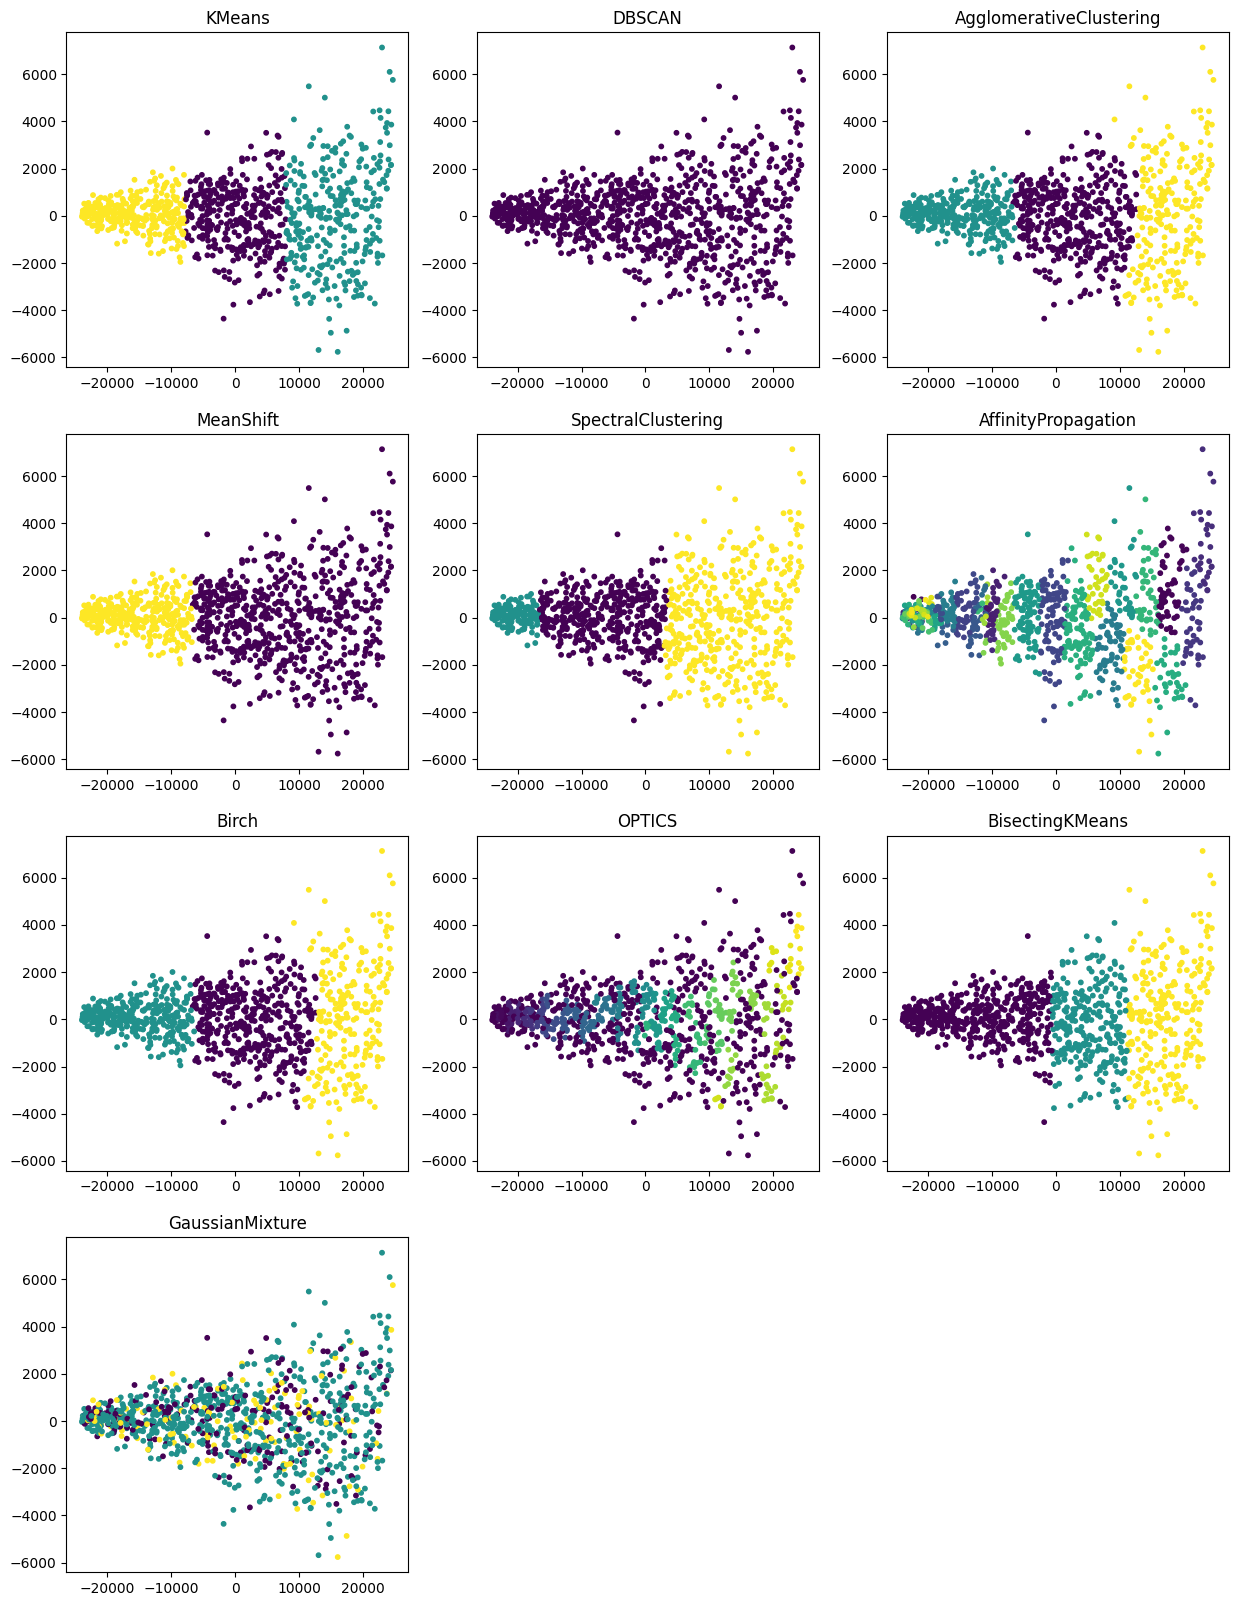

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_pca = pca.fit_transform(customer)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(customer_pca[:, 0], customer_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [11]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [12]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(customer, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.555753,3417.362505,0.550635,0.172665,0.093143,0.868604
DBSCAN,None,None,None,None,None,None
AgglomerativeClustering,0.537102,3051.902276,0.558039,0.164443,0.106866,0.878138
MeanShift,0.567043,2082.497777,0.523213,0.146729,0.123916,0.760677
SpectralClustering,0.51026,2408.929278,0.533532,0.155705,0.031577,0.868424
AffinityPropagation,0.27759,677.132187,0.397964,0.010695,0.006583,0.997909
Birch,0.537102,3051.902276,0.558039,0.164443,0.106866,0.878138
OPTICS,-0.217234,16.802836,2.575068,0.072811,0.018659,NaN
BisectingKMeans,0.499086,2434.460668,0.581423,0.129839,0.095375,0.865717
GaussianMixture,-0.020674,0.054245,137.892403,0.000572,0.006583,0.998814


In [14]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_199475/2114172724.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
MeanShift,0.567043,2082.497777,0.523213,0.146729,0.123916,0.760677,0.335918
AgglomerativeClustering,0.537102,3051.902276,0.558039,0.164443,0.106866,0.878138,0.322043
Birch,0.537102,3051.902276,0.558039,0.164443,0.106866,0.878138,0.322043


# Interpretar

In [15]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [16]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = customer.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing MeanShift with 2 clusters
Ripper Accuracy for MeanShift: 0.96
Decision Tree Accuracy for MeanShift: 1.00
Optimization started

Training time: 40.74s, epochs: 200

Least training loss reached: 0.036
DSGD Accuracy for MeanShift: 0.97
--------------------------------------------------------------------------------
Processing AgglomerativeClustering with 3 clusters
Ripper Accuracy for AgglomerativeClustering: 0.93
Decision Tree Accuracy for AgglomerativeClustering: 1.00
Optimization started

Training time: 41.11s, epochs: 200

Least training loss reached: 0.051
DSGD Accuracy for AgglomerativeClustering: 0.92
--------------------------------------------------------------------------------
Processing Birch with 3 clusters
Ripper Accuracy for Birch: 0.93
Decision Tree Accuracy for Birch: 1.00
Optimization started

Training time: 41.46s, epochs: 200

Least training loss reached: 0.051
DSGD Accuracy for Birch: 0.92
---------------------------------------------------------------------

# Primer algoritmo

In [17]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[income=40934.6-45415.6] V [income=32170.4-36608.6] V [income=24009.4-28126.0] V [income=36608.6-40934.6] V [income=>45415.6] V [income=28126.0-32170.4] V [income=19480.1-24009.4^purchase_amount=8279.2-9647.5] V [income=19480.1-24009.4^product_Clothing=0^product_Food=0^product_Electronics=0] V [income=19480.1-24009.4^age=26.0-28.0^purchase_amount=6710.8-8279.2] V [income=19480.1-24009.4^age=31.0-32.0]]

Reglas para clase: 1
[[income=<9367.0] V [income=9367.0-14747.8] V [income=14747.8-19480.1] V [income=19480.1-24009.4^purchase_amount=5014.8-6710.8] V [income=19480.1-24009.4^education=1^gender=0] V [income=19480.1-24009.4^promotion_usage=1^gender=0^purchase_amount=6710.8-8279.2]]


Decision Tree:


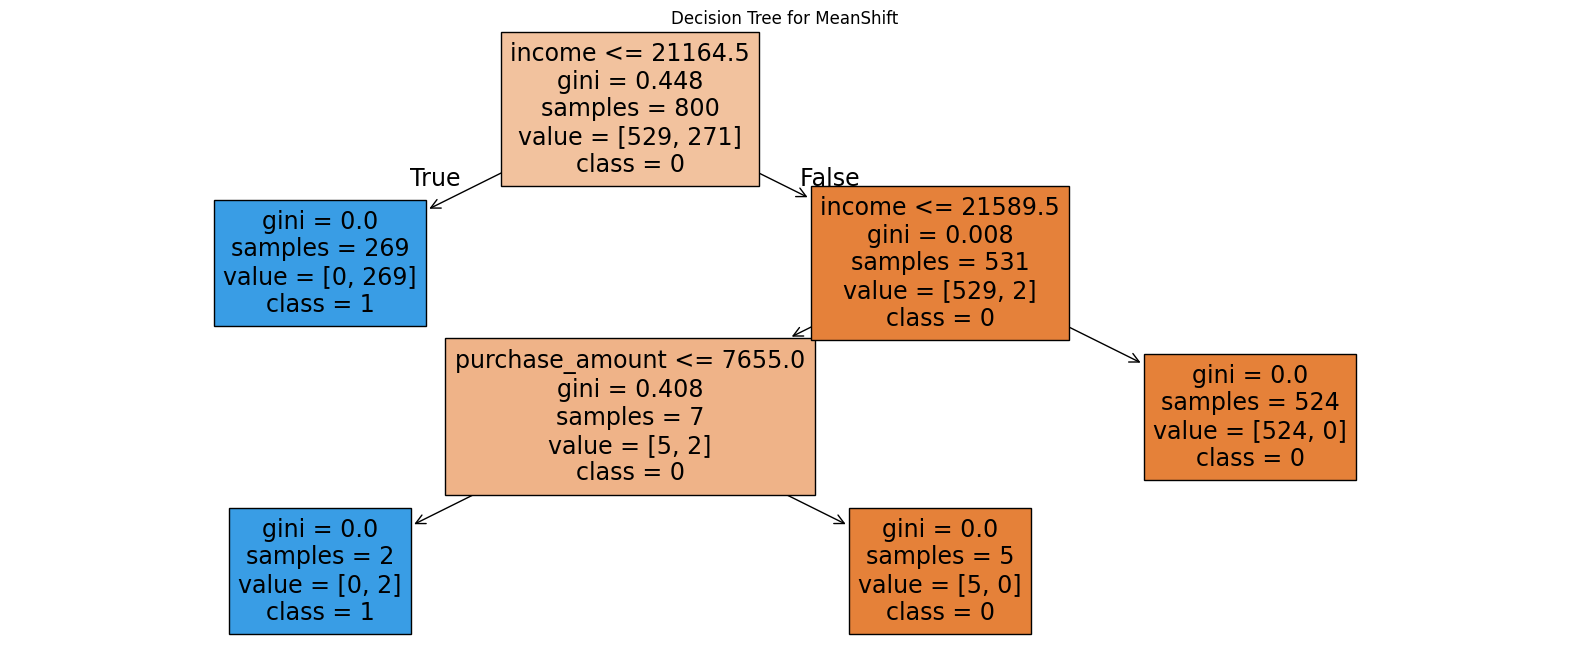

In [18]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=customer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [19]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.707] R8: 27836.295 < income < 36488.967
			0: 0.707	1: 0.000	Unc: 0.293

	[0.660] R9: income > 36488.967
			0: 0.660	1: 0.000	Unc: 0.340

	[0.608] R19: 9773.680 < purchase_amount < 13022.512
			0: 0.608	1: 0.000	Unc: 0.392

	[0.555] R20: purchase_amount > 13022.512
			0: 0.555	1: 0.000	Unc: 0.445

	[0.466] R7: 19183.623 < income < 27836.295
			0: 0.466	1: 0.000	Unc: 0.534

Most important rules for class 1

	[0.731] R17: purchase_amount < 6524.848
			0: 0.000	1: 0.731	Unc: 0.269

	[0.702] R6: income < 19183.623
			0: 0.000	1: 0.702	Unc: 0.298
--------------------------------------------------------------------------------


# Segundo algoritmo

In [20]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[income=28126.0-32170.4] V [income=32170.4-36608.6] V [income=24009.4-28126.0] V [income=19480.1-24009.4^purchase_amount=8279.2-9647.5] V [income=36608.6-40934.6^purchase_amount=12444.9-14099.4^region_South=0] V [income=19480.1-24009.4^loyalty_Regular=0^age=26.0-28.0] V [income=19480.1-24009.4^age=<24.0] V [income=19480.1-24009.4^promotion_usage=0^region_South=1] V [income=36608.6-40934.6^purchase_amount=10887.6-12444.9^education=1] V [income=19480.1-24009.4^gender=1^product_Electronics=0^purchase_amount=6710.8-8279.2] V [product_Home=1^income=19480.1-24009.4]]

Reglas para clase: 1
[[income=<9367.0] V [income=9367.0-14747.8] V [income=14747.8-19480.1] V [income=19480.1-24009.4^purchase_amount=5014.8-6710.8] V [income=19480.1-24009.4^education=1^gender=0] V [income=19480.1-24009.4^purchase_amount=6710.8-8279.2^product_Electronics=1] V [income=19480.1-24009.4^promotion_usage=1^gender=0^purchase_amount=6710.8-8279.2]]

Reglas para clase: 2
[[income=40

Decision Tree:


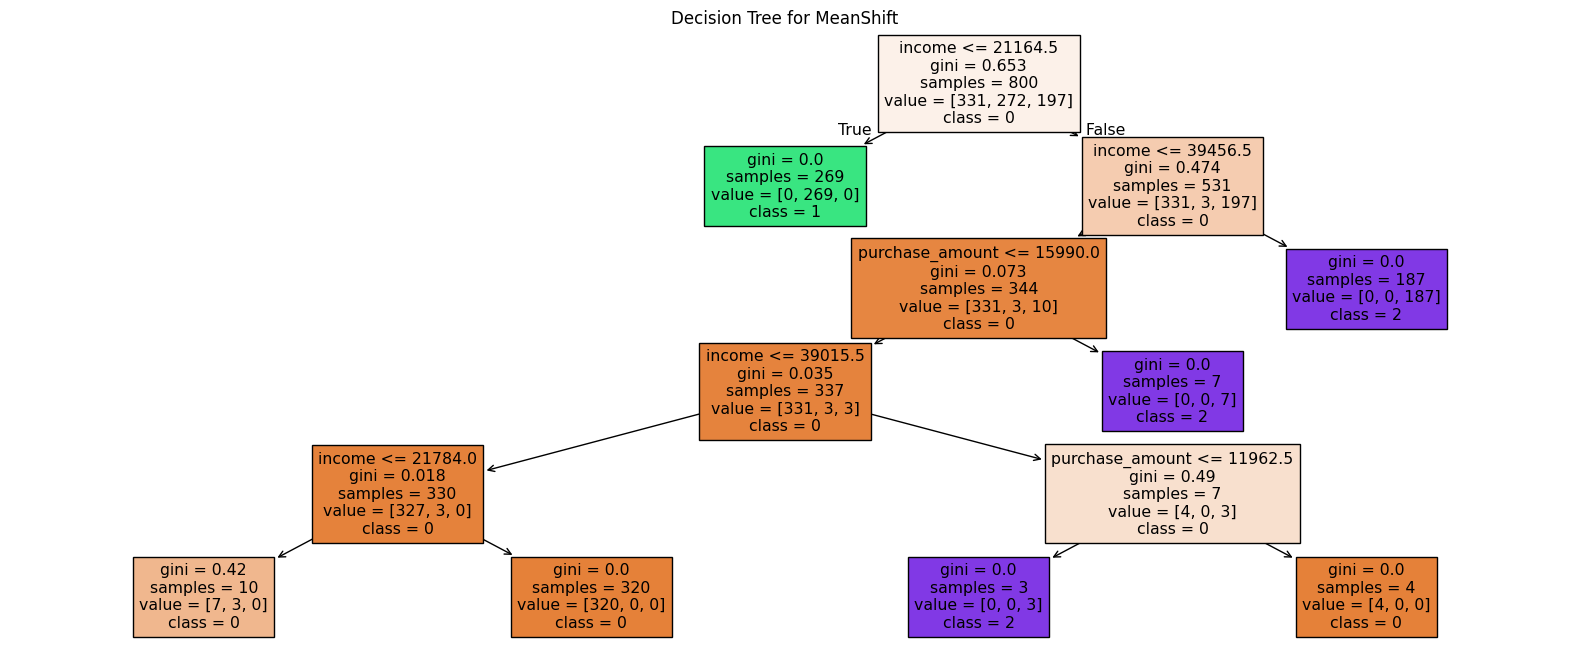

In [21]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=customer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [22]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.803] R8: 27836.295 < income < 36488.967
			0: 0.803	1: 0.000	2: 0.000	Unc: 0.197

	[0.746] R19: 9773.680 < purchase_amount < 13022.512
			0: 0.649	1: 0.000	2: 0.208	Unc: 0.143

	[0.666] R7: 19183.623 < income < 27836.295
			0: 0.640	1: 0.054	2: 0.000	Unc: 0.306

	[0.648] R18: 6524.848 < purchase_amount < 9773.680
			0: 0.553	1: 0.205	2: 0.000	Unc: 0.241

	[0.371] R20: purchase_amount > 13022.512
			0: 0.163	1: 0.000	2: 0.685	Unc: 0.153

	[0.330] R45: loyalty_Regular = 0
			0: 0.296	1: 0.070	2: 0.000	Unc: 0.633

Most important rules for class 1

	[0.736] R6: income < 19183.623
			0: 0.000	1: 0.736	2: 0.000	Unc: 0.264

	[0.628] R17: purchase_amount < 6524.848
			0: 0.000	1: 0.628	2: 0.000	Unc: 0.372

	[0.395] R18: 6524.848 < purchase_amount < 9773.680
			0: 0.553	1: 0.205	2: 0.000	Unc: 0.241

Most important rules for class 2

	[0.762] R20: purchase_amount > 13022.512
			0: 0.163	1: 0.000	2: 0.685	Unc: 0.153

	[0.751] R9: income > 36488.

# Tercer algoritmo

In [23]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[income=28126.0-32170.4] V [income=32170.4-36608.6] V [income=24009.4-28126.0] V [income=19480.1-24009.4^purchase_amount=8279.2-9647.5] V [income=36608.6-40934.6^purchase_amount=12444.9-14099.4^region_South=0] V [income=19480.1-24009.4^loyalty_Regular=0^age=26.0-28.0] V [income=19480.1-24009.4^age=<24.0] V [income=19480.1-24009.4^promotion_usage=0^region_South=1] V [income=36608.6-40934.6^purchase_amount=10887.6-12444.9^education=1] V [income=19480.1-24009.4^gender=1^product_Electronics=0^purchase_amount=6710.8-8279.2] V [product_Home=1^income=19480.1-24009.4]]

Reglas para clase: 1
[[income=<9367.0] V [income=9367.0-14747.8] V [income=14747.8-19480.1] V [income=19480.1-24009.4^purchase_amount=5014.8-6710.8] V [income=19480.1-24009.4^education=1^gender=0] V [income=19480.1-24009.4^purchase_amount=6710.8-8279.2^product_Electronics=1] V [income=19480.1-24009.4^promotion_usage=1^gender=0^purchase_amount=6710.8-8279.2]]

Reglas para clase: 2
[[income=40

Decision Tree:


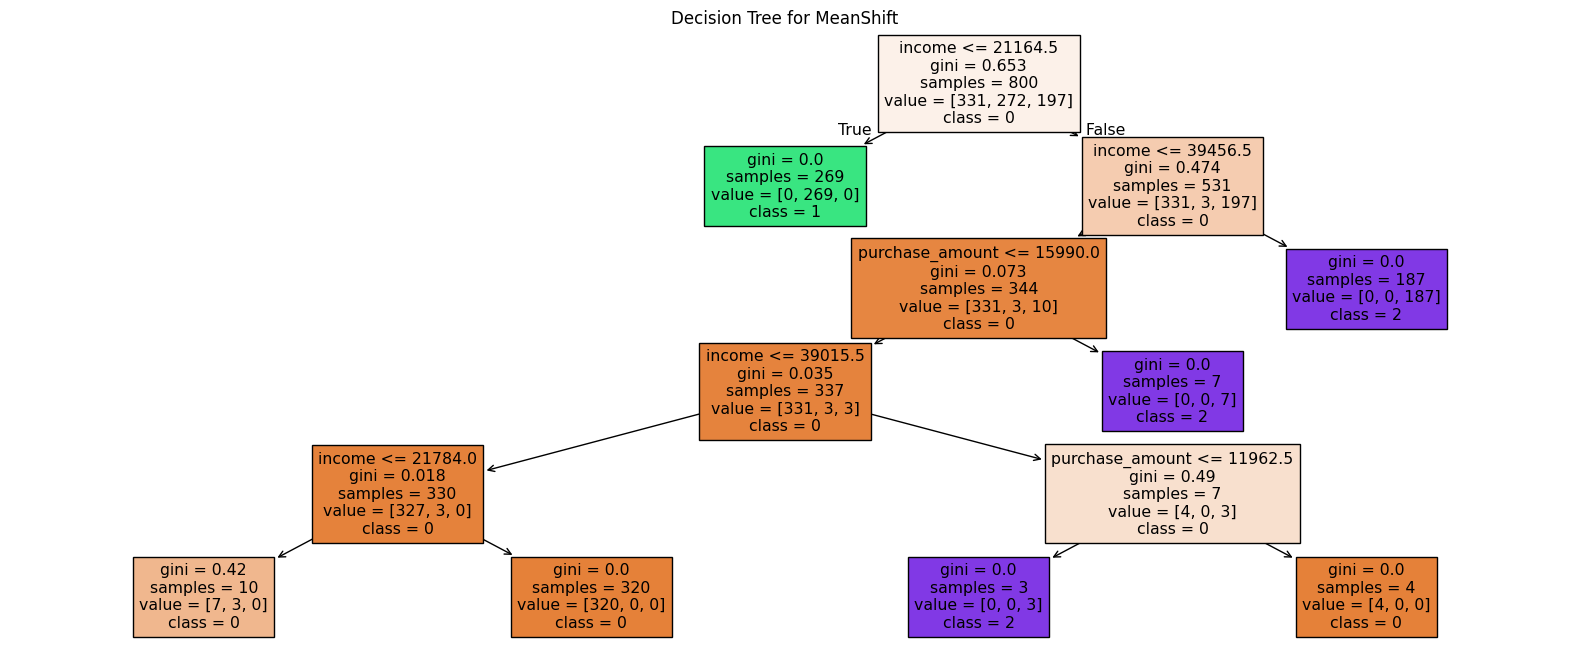

In [24]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=customer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [25]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.765] R8: 27836.295 < income < 36488.967
			0: 0.765	1: 0.000	2: 0.000	Unc: 0.235

	[0.738] R19: 9773.680 < purchase_amount < 13022.512
			0: 0.651	1: 0.000	2: 0.187	Unc: 0.162

	[0.642] R18: 6524.848 < purchase_amount < 9773.680
			0: 0.530	1: 0.246	2: 0.000	Unc: 0.224

	[0.610] R7: 19183.623 < income < 27836.295
			0: 0.595	1: 0.030	2: 0.000	Unc: 0.375

	[0.352] R45: loyalty_Regular = 0
			0: 0.325	1: 0.056	2: 0.000	Unc: 0.619

	[0.345] R44: product_Home = 1
			0: 0.304	1: 0.088	2: 0.000	Unc: 0.608

	[0.323] R20: purchase_amount > 13022.512
			0: 0.131	1: 0.000	2: 0.666	Unc: 0.203

Most important rules for class 1

	[0.736] R6: income < 19183.623
			0: 0.000	1: 0.736	2: 0.000	Unc: 0.264

	[0.708] R17: purchase_amount < 6524.848
			0: 0.000	1: 0.708	2: 0.000	Unc: 0.292

	[0.437] R18: 6524.848 < purchase_amount < 9773.680
			0: 0.530	1: 0.246	2: 0.000	Unc: 0.224

Most important rules for class 2

	[0.780] R9: income > 36488.967
			0: 0